In [85]:
from random import sample

# 常规导包
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, firwin2, fftconvolve,stft,filtfilt
from scipy.io import savemat,loadmat
from scipy.interpolate import interp1d


In [86]:
def generate_target_psd_noise(filter_order,samples,psd,noise,freq_vec):
    b = firwin2(filter_order + 1,freq_vec/(samples/2) ,np.sqrt(psd))
    output_noise = np.sqrt(samples)* fftconvolve(b,noise)
    return output_noise
def innerprodpsd(xVec,yVec,sampFreq,psdVals):
    nsamples  = len(xVec)
    if len(yVec) !=nsamples:
        raise  ValueError('Vectors must be of the same length')
    kNyq = nsamples //2
    psdVals = psdVals[:kNyq]
    if len(psdVals)  != kNyq:
        raise ValueError('PSD values must be specified at positive  DFT  freqencies')
    fftX = np.fft.fft(xVec)
    fftY = np.fft.fft(yVec)
    
    negFStrt = 1- (nsamples % 2)
    psdVec4Norm = np.concatenate((psdVals,psdVals[kNyq  - negFStrt::-1][0:]))
    dataLen = sampFreq* nsamples
    innProd  = (1 / dataLen) * np.dot(fftX/ (psdVec4Norm[:len(fftX)] + 1e-35),np.conj(fftY))
    innProd = np.real(innProd)
    return innProd
    

## SIS Model波形
#### 波形公式
- 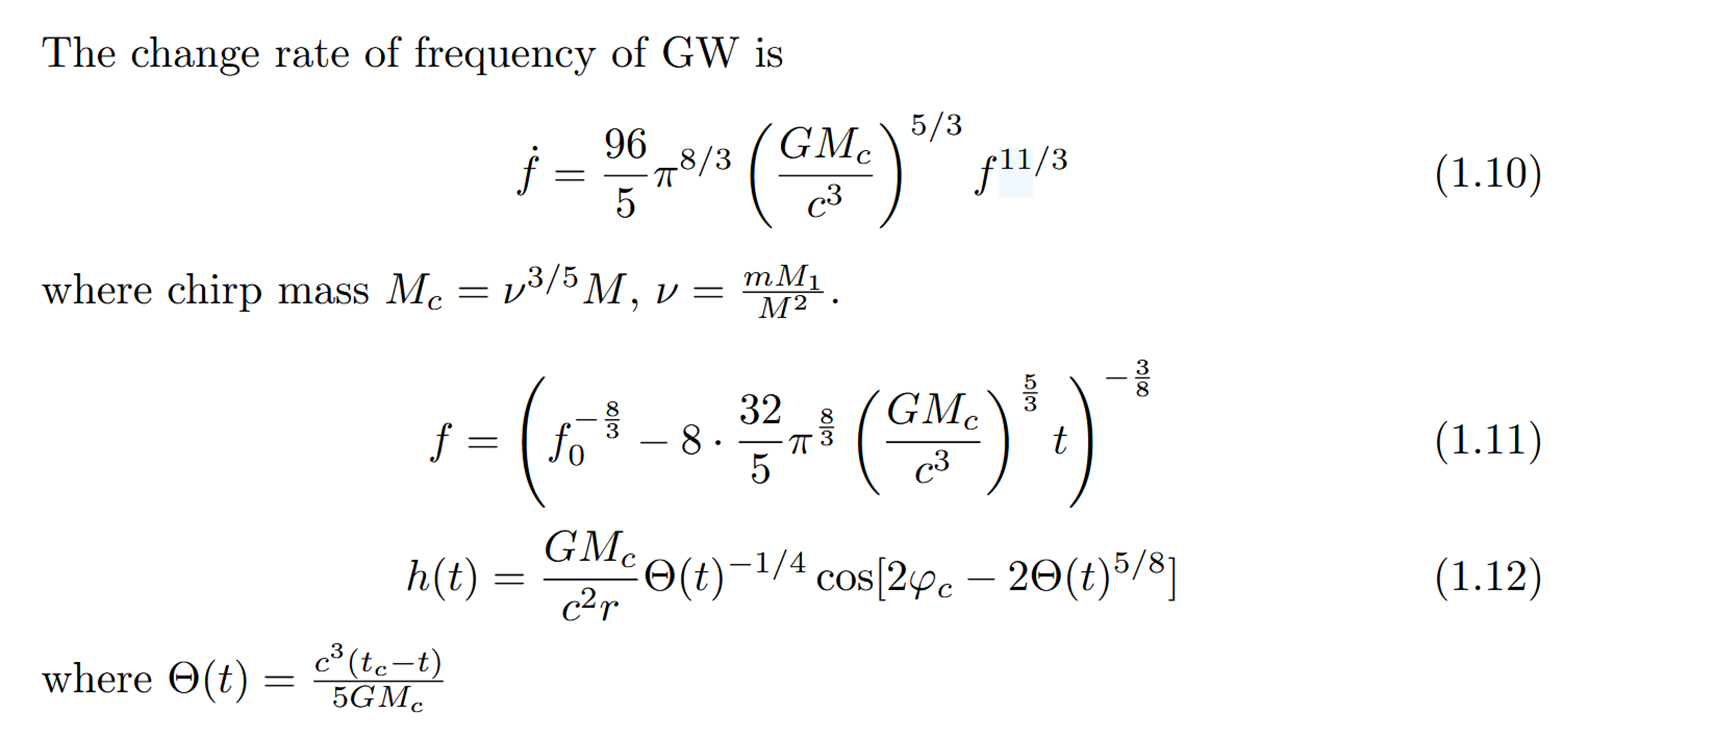
#### 透镜公式
- 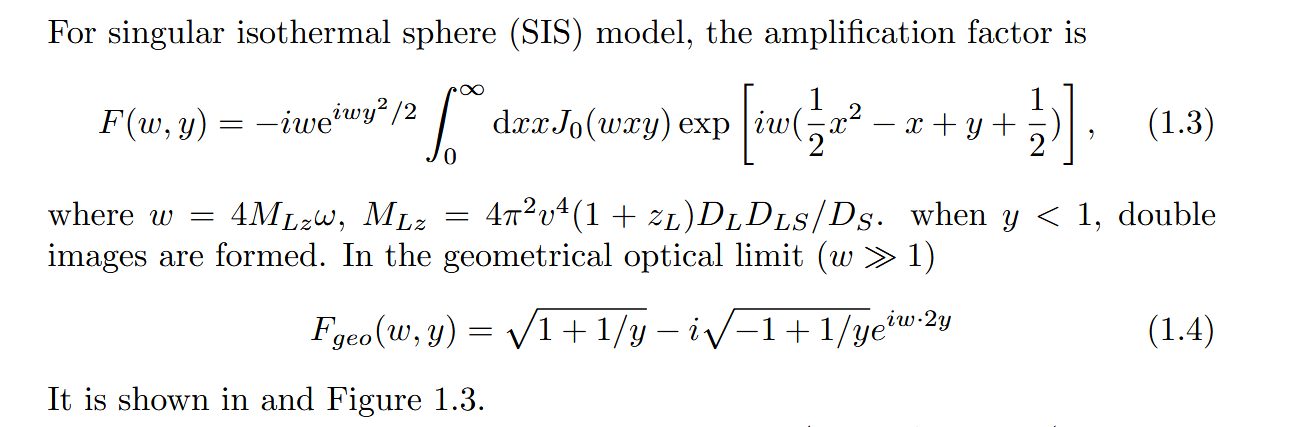
#### 待观测数据
- 所需探测范围
    - 信号：
        - r:1e20 ~ 1e25
        - Mc:1e31 ~ 2e31
        - tc: -1 ~ 1
        - phi_c: -2*np.pi ~ 2*np.pi
    - 透镜：
        - Mlz:1e36 ~ 1e37
        - y:0~0.5

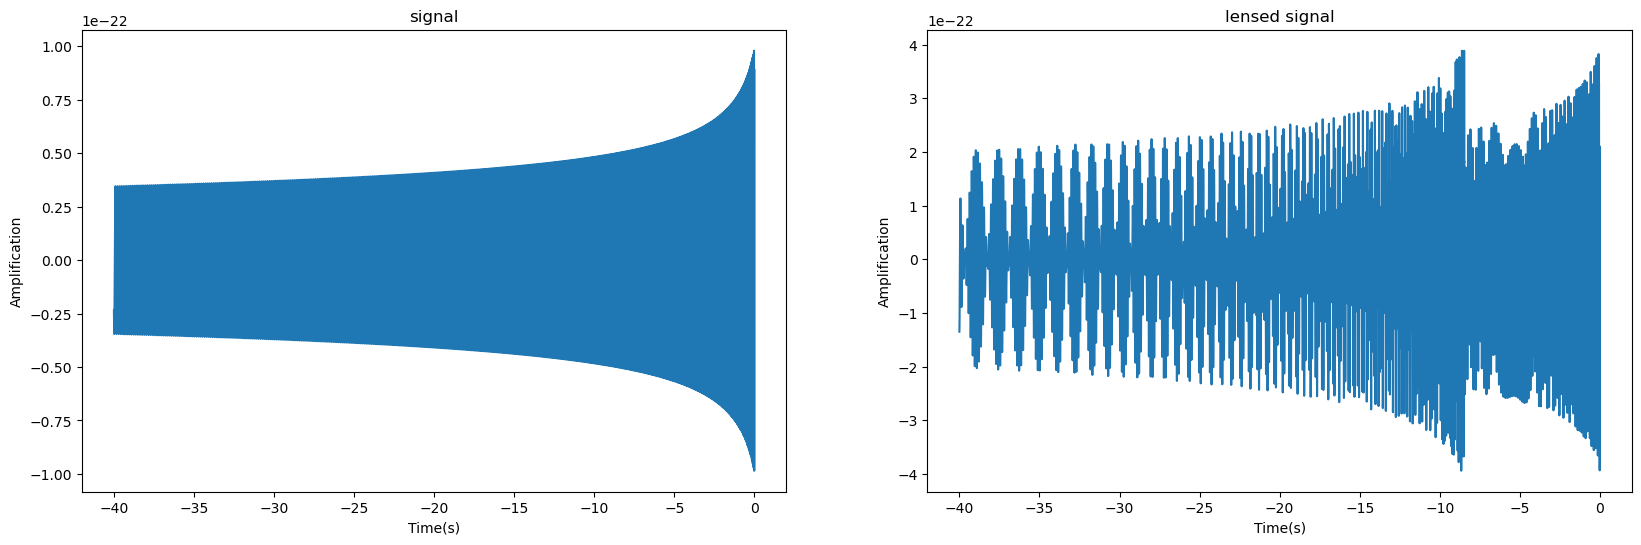

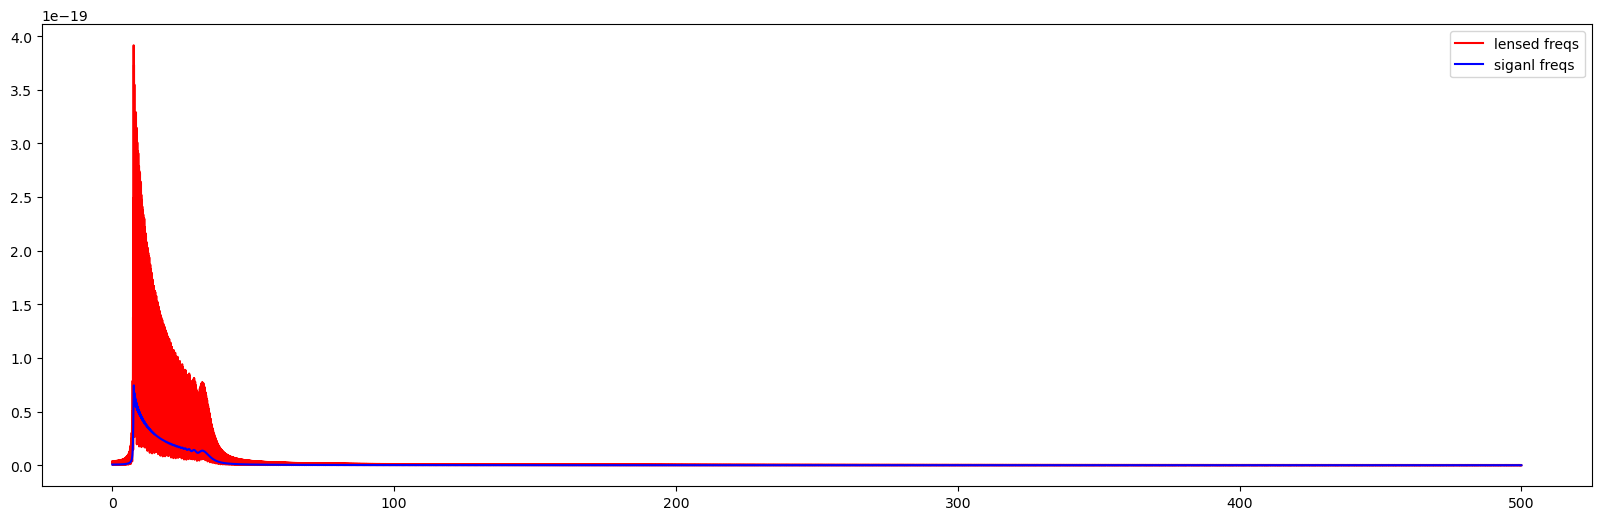

False


In [87]:
# 生成SIS模型波形

# 常量定义
# nsamples = 200000
# samples = 20000
G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
c = 2.998e8  # 光速, m/s
M_sun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

# 变量定义
# 定义质量变量
M1 = 10 * M_sun
M2 = 25 * M_sun
M = (M1 + M2)
v = M1 * M2 / M ** 2 # 质量比
M_c = v ** (3 / 5) * M  # 啁啾质量
r = 1e3*1e6 * pc # 引力波源到观测者的距离  单位Mpc
t_c = 0.6 # 合并时间
phi_c = 1/2 * np.pi # 合并时刻的相位



# t = np.linspace(-100,0,30000)
# 采样率1000HZ
t = np.arange(-40,0,0.001)

# 定义引力波信号函数
def generate_h_t(t,M_c,r,phi_c):
    theta_t= c**3 *(t_c - t) / (5 * G * M_c)
    h = G * M_c /(c ** 2 * r) * theta_t**(-1/4)*np.cos(2*phi_c - 2*theta_t**(5/8)) # r控制信号振幅大小，r越大，振幅越小
    return h
# 生成信号
h = generate_h_t(t,M_c,r,phi_c)
# h = h[:-1]
# t = t[:-1]
# 去掉信号inf的情况
# 将信号转换到频域
h_f = np.fft.rfft(h)

# 生成频率
freqs = np.fft.rfftfreq(len(h),t[1] - t[0])

# 透镜参数定义
# Dl = 1e8 * pc  # 透镜到观测者的距离
# Ds = 1.5e8 * pc # 波源到透镜的距离
# Dls = Ds - Dl # 波源都观测者的距离
# v = 1e6 # 透镜系统的速度弥散
# zl = 0.5 # 红移
# Mlz = 4*np.pi**2 * v **4 *(1 + zl) * Dl * Dls / Ds
# print(Mlz / M_sun)
Mlz = 1e7 * M_sun

omega = 2 * np.pi * freqs
w = G * 4 *Mlz * omega / c**3
y = 0.123

# 定义光学极限的透镜化
def generate_f_geo(w,y):
    F_geo = np.sqrt(1 + 1/y) - 1j * np.lib.scimath.sqrt(-1 + 1 / y) * np.exp(1j * w * 2 * y)
    return F_geo
# 生成透镜化，频域
F_geo = generate_f_geo(w,y)

# h_lens = h * F_geo
# 将信号透镜化 （频域）
lens_f = h_f * F_geo
# 逆傅里叶变换将频域信号转换为时域信号
h_lens = np.fft.irfft(lens_f)

# # 画图
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(t,h.real,label = 'signal')
plt.xlabel('Time(s)')
plt.ylabel('Amplification')
plt.title('signal')
# t = t[:-1]
plt.subplot(1,2,2)
plt.plot(t,h_lens.real,label = 'lensed signal')
plt.xlabel('Time(s)')
plt.ylabel('Amplification')
plt.title('lensed signal')


plt.show()


plt.figure(figsize=(20,6))
plt.plot(freqs,np.abs(lens_f),'red',label = 'lensed freqs')
plt.plot(freqs,np.abs(h_f),'blue',label = 'siganl freqs')
plt.legend()
plt.show()
print(np.isinf(h_lens).any())


## LIGO提供的PSD相关数据

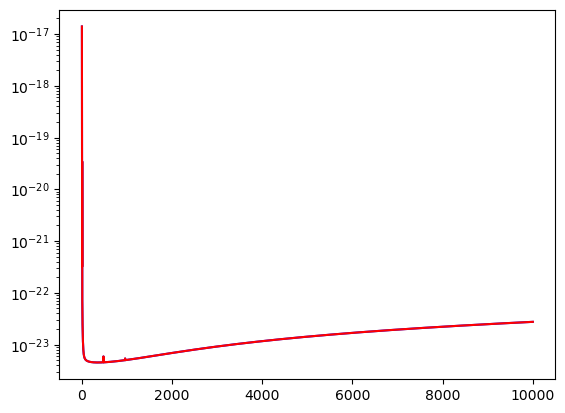

40000


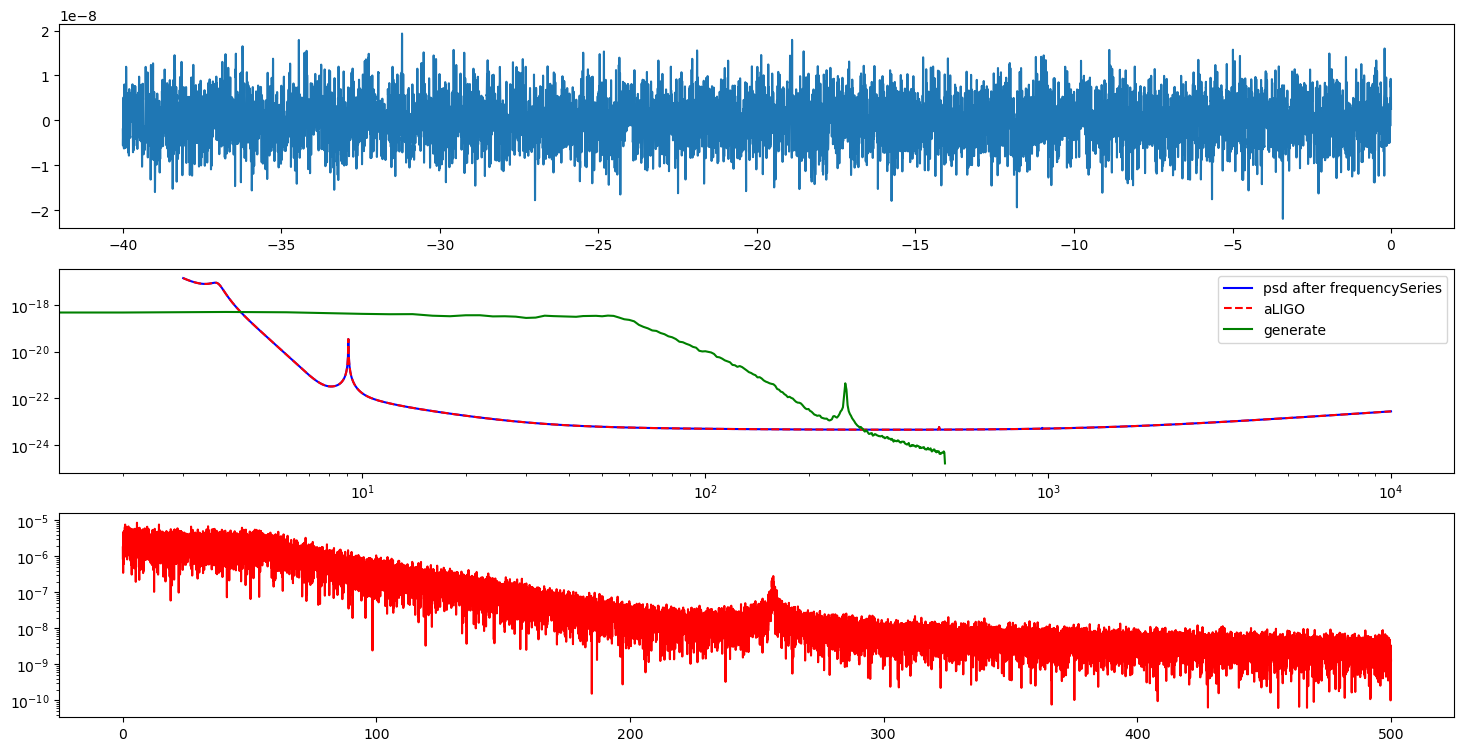

In [ ]:
import numpy as np
from pycbc.noise import noise_from_psd
from pycbc.types import FrequencySeries, TimeSeries
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# 获取频率和噪声功率谱密度
freq_psd = np.loadtxt('aligo_design.txt')

posfreqs = freq_psd[:,0]
psd = freq_psd[:,1]

# posfreqs[0] = 0
psd_ligo_map = interp1d(posfreqs,psd)

fig = plt.figure()
plt.plot(posfreqs, psd, 'b')
plt.plot(posfreqs,psd_ligo_map(posfreqs),'r')
plt.yscale('log')
plt.show()

t = np.arange(-40,0,0.001)
nsamples = len(t)
tlen = int(t[-1] - t[0] + 1)
delta_f = 1/ tlen
samples = nsamples / tlen
print(nsamples)
# freqs = np.arange(3,nsamples//2 + delta_f,delta_f)
# interp1ded_psd = psd_ligo_map(freqs)
psd_series = FrequencySeries(psd,delta_f=delta_f)

noise = noise_from_psd(nsamples,delta_f,psd_series,seed=516)
# t_noise = TimeSeries(noise,delta_t=1.0 / samples)



f_noise = np.fft.rfft(noise)
noise_freqs = np.fft.rfftfreq(len(noise),t[1] - t[0]) 

f,pxx = welch(noise,fs = samples,nperseg=samples//2)    
plt.figure(figsize=(18,9))
plt.subplot(311)
plt.plot(t,noise)


plt.subplot(312)
plt.plot(posfreqs,psd_series,'b-',label ='psd after frequencySeries')
plt.plot(posfreqs,psd,'r--',label = 'aLIGO')
plt.plot(f,pxx,'g',label= 'generate')
plt.yscale('log')
plt.xscale('log')
# plt.xlim(0,500)
plt.legend()



plt.subplot(313)
plt.plot(noise_freqs,np.abs(f_noise),'r')
plt.yscale('log')
plt.show()




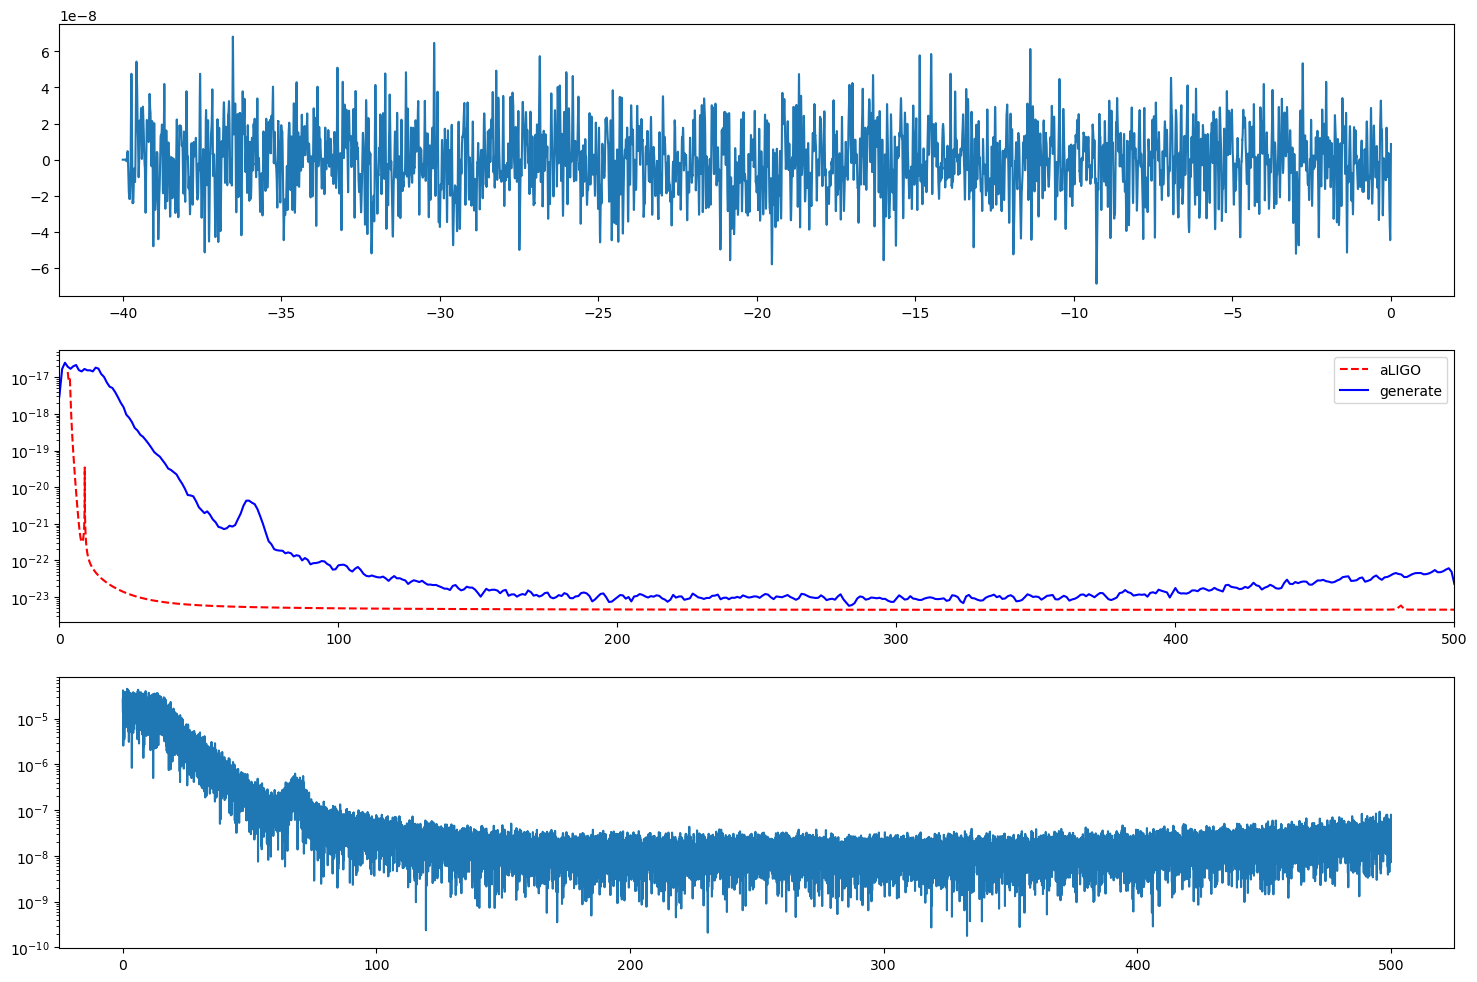

In [115]:
# 这个是不是跟滤波器的一样啊
np.random.seed(516)
initial_noise = np.random.normal(0,1,nsamples)
filter_order = 300
freqs = np.linspace(0,samples/2,3000)
output_noise = generate_target_psd_noise(filter_order=filter_order,samples=samples,psd=psd,noise=initial_noise,freq_vec=freqs)

f,pxx = welch(output_noise,fs = samples,nperseg=samples)

# 看下频域
f_noise = np.fft.rfft(output_noise)
f_freqs = np.fft.rfftfreq(len(output_noise),t[1]-t[0])


fig = plt.figure(figsize=(18,12))
plt.subplot(311)
output_noise = output_noise[:len(t)]
plt.plot(t,output_noise)


plt.subplot(312)
plt.plot(posfreqs,psd,'r--',label = 'aLIGO')
plt.plot(f,pxx,'b',label = 'generate')
plt.yscale('log')
plt.xlim(0,500)
# plt.xscale('log')
plt.legend()

plt.subplot(313)
plt.plot(f_freqs,np.abs(f_noise))
plt.yscale('log')
plt.show()



# 将噪声混入信号
- 左图为透镜化之后的信号以及噪声情况
- 右图为透镜化之后的信号与混合数据的情况
- 取值情况为噪声约为信号的10-100倍强度
## 之后用数据代指       透镜化信号+噪声

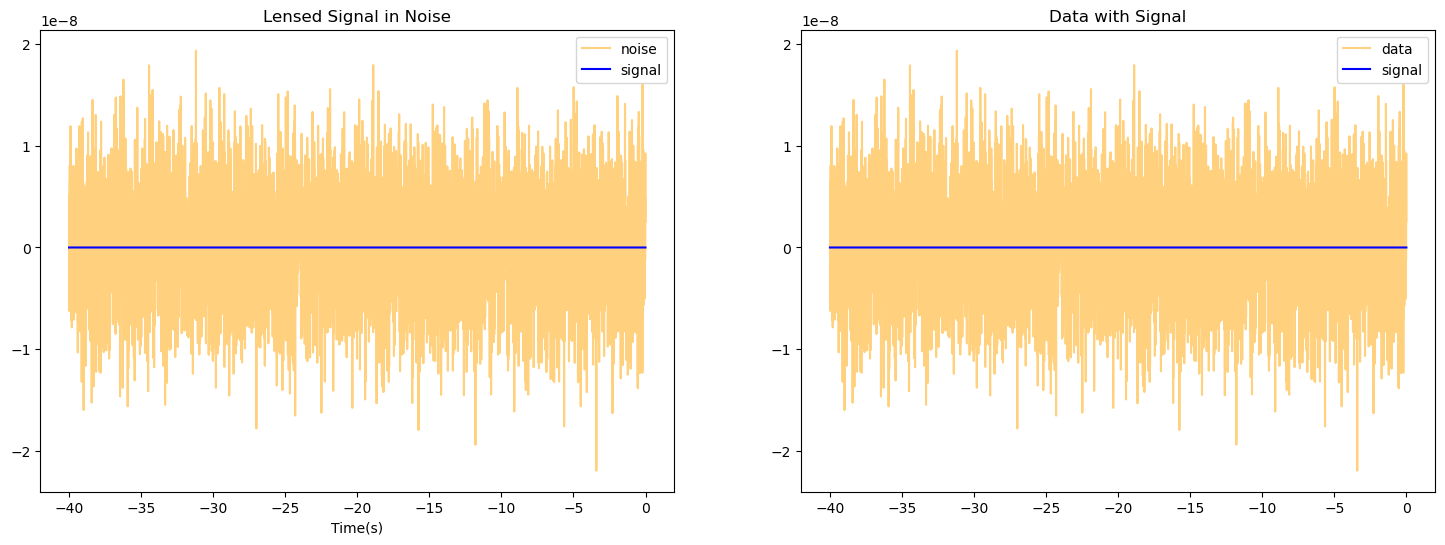

In [90]:
# h = h[:len(output_noise)]
# data = h + output_noise

data = h_lens + noise


fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# 第一个子图
axs[0].plot(t, noise, "orange", label="noise", alpha=0.5)
axs[0].plot(t, h_lens, "blue", label='signal')
axs[0].set_xlabel("Time(s)")
axs[0].set_title("Lensed Signal in Noise")
axs[0].legend()

# 第二个子图
axs[1].plot(t, data, "orange", label="data", alpha=0.5)
axs[1].plot(t, h_lens, "blue", label='signal')
axs[1].set_title("Data with Signal")
axs[1].legend()

plt.show()

# savemat('data.mat',{'data':data,'samples':samples})
# print(np.isinf(data).any())

# 绘制噪声与数据的功率谱密度
- 蓝色线代表总数据
- 橙色线代表纯噪声


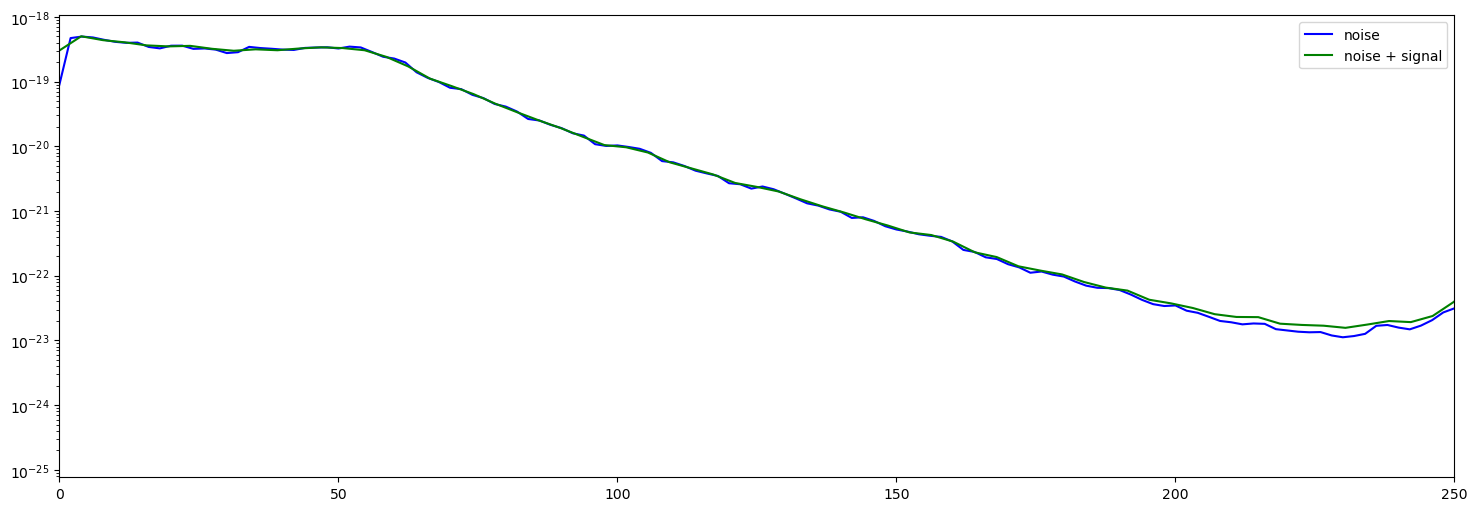

In [91]:
[f_data,pxx_data] = welch(data,fs = samples,window = "hamming",nperseg=256,noverlap=None,nfft=None,detrend = False)

fig = plt.figure(figsize=(18,6))
plt.plot(f,pxx,'blue',label = 'noise')
plt.plot(f_data,pxx_data,"green",label = 'noise + signal')
plt.yscale('log')
plt.legend()
plt.xlim(0,250)
plt.show()

In [92]:
# 查看数据是否可以调用
data = loadmat("data.mat")
noise = loadmat("noise.mat")

samples_data = data['samples'][0]
dataY = data['data'][0]
noise_y = noise['noise'][0]
dataY_FFT = np.fft.fft(dataY)
print(np.any(np.isinf(dataY_FFT)))

False


## 信噪比
- 在学习信噪比时看到的一个很好理解的视频
    - https://www.bilibili.com/video/BV1NG411b7qD/?spm_id_from=333.1391.0.0&vd_source=6653954c04b5fa19db6e649a79e0d4dd

In [93]:
# # 计算信噪比
# llrH0 = np.zeros(1000)
# for lp in range(len(llrH0)):
#     llrH0[lp] = innerprodpsd(noise_y,h_lens,samples_data,freqs)
# llrH1 = np.zeros(1000)
# for lp in range(len(llrH1)):
#     llrH1[lp] = innerprodpsd(dataY,h_lens,samples_data,freqs)

# estSNR = (np.mean(llrH1) - np.mean(llrH0)) / np.std(llrH0)

# print(estSNR)


In [94]:
print(f"r: {r / 1e6 / pc:.4e} m_c: {M_c/M_sun:.4f} t_c: {t_c} phi_c: {phi_c / np.pi} Mlz: {Mlz/M_sun:.4e} y: {y}")

r: 1.0000e+03 m_c: 13.4881 t_c: 0.6 phi_c: 0.5 Mlz: 1.0000e+07 y: 0.123
